The Gravity Model (Econometrics) 
===========================

The gravity model relates international trade flows
    between country $\ell$ and country $n$ via the 
    equation 
    
$$
    T_{\ell n} = 
    \frac{\lambda \xi_{\ell n} G_\ell^{\alpha} G_n^\beta}
    {D_{\ell n}^{\gamma}}
$$

Here $T_{\ell n}$ is exports from country $\ell$ to country $n$, $\lambda$ is a constant term, $\xi_{\ell n}$ is a
    shock, $G_\ell$ and $G_n$ are GDP in country $\ell$  and $n$ respectively,
    and $D_{\ell n}$ is distance between them.  Taking logs gives the
    linear model

$$
    \ln T_{\ell n} 
        = \ln \lambda 
        +  \alpha \ln G_\ell + \beta \ln G_n - \gamma \ln D_{\ell n}
        + \ln \xi_{\ell n}
$$

Here our aim is to give a simple example of linear regression based around this example, using Python's [statsmodels](http://statsmodels.sourceforge.net/) and [pandas](http://pandas.pydata.org/).

Data
-----
Trade data is sourced from: http://atlas.media.mit.edu/en/resources/data and uses the SITC rev 2. product level trade dataset. This product level data is aggregated to form a bilateral trade dataset at the country level.

Distance and Geography is sourced from CEPII: http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6

GDP and Population statistics are from the World Development Indicators: http://data.worldbank.org/data-catalog/world-development-indicators

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from numpy import log
import statsmodels.formula.api as smf

Import the data from a ``csv`` data file for the year 2013

In [3]:
data = pd.read_csv(r"./data/gravity_dataset_2013.csv")

Let's have a look at the first few rows.

In [4]:
data.head()

,year,iiso3c,eiso3c,value,contig,comlang_off,colony,dist,distcap,distw,distwces,ell,ill,egdp,egdppc,epop,igdp,igdppc,ipop
0,2013,ABW,BEL,774353.0,0,1,0,7847.070,7847.070,7843.255,7843.006,0,0,4.204710e+11,37599.735498,1.118282e+07,NaN,NaN,102921.0
1,2013,ABW,BHS,4712537.0,0,0,0,1588.515,1588.515,1634.515,1628.143,0,0,7.835118e+09,20736.547344,3.778410e+05,NaN,NaN,102921.0
2,2013,ABW,CHE,17812626.0,0,0,0,8056.332,8056.332,8074.21,8073.511,1,0,4.772463e+11,58996.896141,8.089346e+06,NaN,NaN,102921.0
3,2013,ABW,CHN,25319168.0,0,0,0,14155.350,14155.350,14590.92,14560.28,0,0,4.912954e+12,3619.439108,1.357380e+09,NaN,NaN,102921.0
4,2013,ABW,COL,22160086.0,0,1,0,1036.634,1036.634,929.5887,861.2452,0,0,2.129079e+11,4497.196936,4.734236e+07,NaN,NaN,102921.0


Description of the data

In [5]:
data.shape

(22695, 19)

The names of all the variables are as follows:

In [6]:
data.columns

Index(['year', 'iiso3c', 'eiso3c', 'value', 'contig', 'comlang_off', 'colony',
       'dist', 'distcap', 'distw', 'distwces', 'ell', 'ill', 'egdp', 'egdppc',
       'epop', 'igdp', 'igdppc', 'ipop'],
      dtype='object')

In [7]:
data.describe()

,year,value,contig,comlang_off,colony,dist,distcap,ell,ill,egdp,egdppc,epop,igdp,igdppc,ipop
count,22695.0,2.141300e+04,22695.000000,22695.000000,22695.000000,22695.000000,22695.000000,22695.000000,22695.000000,2.140300e+04,21403.000000,2.269500e+04,2.204600e+04,22046.000000,2.269500e+04
mean,2013.0,7.365519e+08,0.018771,0.149460,0.015113,7626.396993,7607.736961,0.175017,0.174400,3.681618e+11,11998.090079,4.265514e+07,4.707726e+11,14159.274814,5.194448e+07
std,0.0,6.699105e+09,0.135717,0.356549,0.122007,4480.491813,4479.504746,0.379990,0.379461,1.357443e+12,16470.908447,1.522340e+08,1.533534e+12,17685.615815,1.740458e+08
min,2013.0,1.000000e+00,0.000000,0.000000,0.000000,8.300385,8.300385,0.000000,0.000000,2.620733e+07,150.744900,9.876000e+03,1.203875e+08,150.744900,2.091900e+04
25%,2013.0,7.911600e+04,0.000000,0.000000,0.000000,4063.903500,4034.010000,0.000000,0.000000,7.835118e+09,1122.482815,2.346592e+06,1.134676e+10,1776.746022,3.593689e+06
50%,2013.0,2.675794e+06,0.000000,0.000000,0.000000,7216.537000,7205.898000,0.000000,0.000000,2.990891e+10,4480.126282,9.039978e+06,4.530376e+10,5896.096631,1.032223e+07
75%,2013.0,5.730555e+07,0.000000,0.000000,0.000000,10629.535000,10587.270000,0.000000,0.000000,1.961804e+11,15371.305767,3.020105e+07,2.303713e+11,20736.547344,3.657339e+07
max,2013.0,4.220679e+11,1.000000,1.000000,1.000000,19812.040000,19812.040000,1.000000,1.000000,1.445151e+13,79511.205382,1.357380e+09,1.445151e+13,79511.205382,1.357380e+09


In [8]:
data.dtypes

year             int64
iiso3c          object
eiso3c          object
value          float64
contig           int64
comlang_off      int64
colony           int64
dist           float64
distcap        float64
distw           object
distwces        object
ell              int64
ill              int64
egdp           float64
egdppc         float64
epop           float64
igdp           float64
igdppc         float64
ipop           float64
dtype: object

In [9]:
#-Top 10 Importers in 2013
data[['iiso3c', 'value']].groupby("iiso3c").sum().sort_values('value').tail(10)

,value
iiso3c,
ITA,4.451212e+11
IND,4.507656e+11
KOR,4.667622e+11
HKG,5.572411e+11
GBR,6.060486e+11
FRA,6.140013e+11
JPN,7.728603e+11
DEU,1.061542e+12
CHN,1.732984e+12


**Question:** How would you find the top 10 Exporters in 2013?

### Estimation 

Here `egdp` is export country GDP, `igdp` is import country GDP and `dist` is distance.  These are our regressors.  The dependent variable is `value`.

Estimate the basic gravity model

In [10]:
formula = "log(value) ~ log(egdp) + log(igdp) + log(dist)"
model = smf.ols(formula, data)
result = model.fit(cov_type='HC1')

In [11]:
result

In [12]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             log(value)   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 1.203e+04
Date:                Sun, 21 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:01:52   Log-Likelihood:                -47185.
No. Observations:               19655   AIC:                         9.438e+04
Df Residuals:                   19651   BIC:                         9.441e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -30.2350      0.394    -76.773      0.0

### Replication Using Linear Algebra (NumPy)

Let's try to replicate the values of the estimated coefficients $\hat \beta_k$ using matrix algebra.  The first step is to extract the variables we care about and drop all rows with missing values.

In [13]:
data2 = data[['value', 'egdp', 'igdp', 'dist']]
data2 = data2.dropna()

Now let's compute the coefficients directly.

We want to solve the Linear Equation

$$
y = X\beta + \epsilon
$$

which takes the following matrix form:

$$
\begin{pmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_n \\
\end{pmatrix}_{n x 1}
=
\begin{pmatrix}
1 & X_{11} & X_{21} & \cdots & X_{k1} \\
1 & X_{12} & X_{22} & \cdots & X_{k2} \\
\vdots & \vdots & \vdots & \cdots & \vdots \\
1 & X_{1n} & X_{2n} & \cdots & X_{kn} \\
\end{pmatrix}_{n x k}
\begin{pmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_n \\
\end{pmatrix}_{k x 1}
+
\begin{pmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n \\
\end{pmatrix}_{n x 1}
$$

Solving this system of equations using Linear Algebra gives the solution for the $\beta$ coefficients

$$
\beta = (X'X)^{-1}X'y 
$$

In [14]:
from numpy.linalg import inv

y = np.asarray(np.log(data2.value))
X = np.ones((len(y), 4))
X[:, 1] = log(data2.egdp)
X[:, 2] = log(data2.igdp)
X[:, 3] = log(data2.dist)

betahat = inv(X.T @ X) @ X.T @ y
print(betahat)

[-30.23498073   1.27825004   1.02865139  -1.34830012]


Sure enough, the values match with those given in the table above.

### Additional Regressors

Estimate the model with some additional explanatory variables

In [15]:
model2 = smf.ols("log(value) ~ log(egdp) + log(igdp) + log(dist)+\
                  contig + comlang_off + colony + ell + ill", data)
result2 = model2.fit()
result2 = result2.get_robustcov_results()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:             log(value)   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     4991.
Date:                Sun, 21 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:01:52   Log-Likelihood:                -46736.
No. Observations:               19655   AIC:                         9.349e+04
Df Residuals:                   19646   BIC:                         9.356e+04
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -30.5841      0.397    -77.092      

Estimating the model with GDPPC instead of GDP

Plotting
--------

A plot of components of the basic model

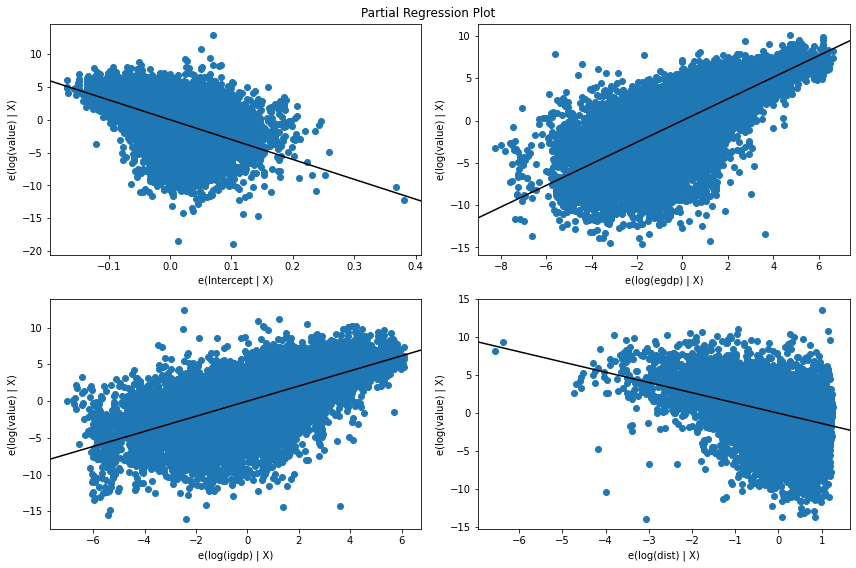

In [16]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(result, fig=fig)

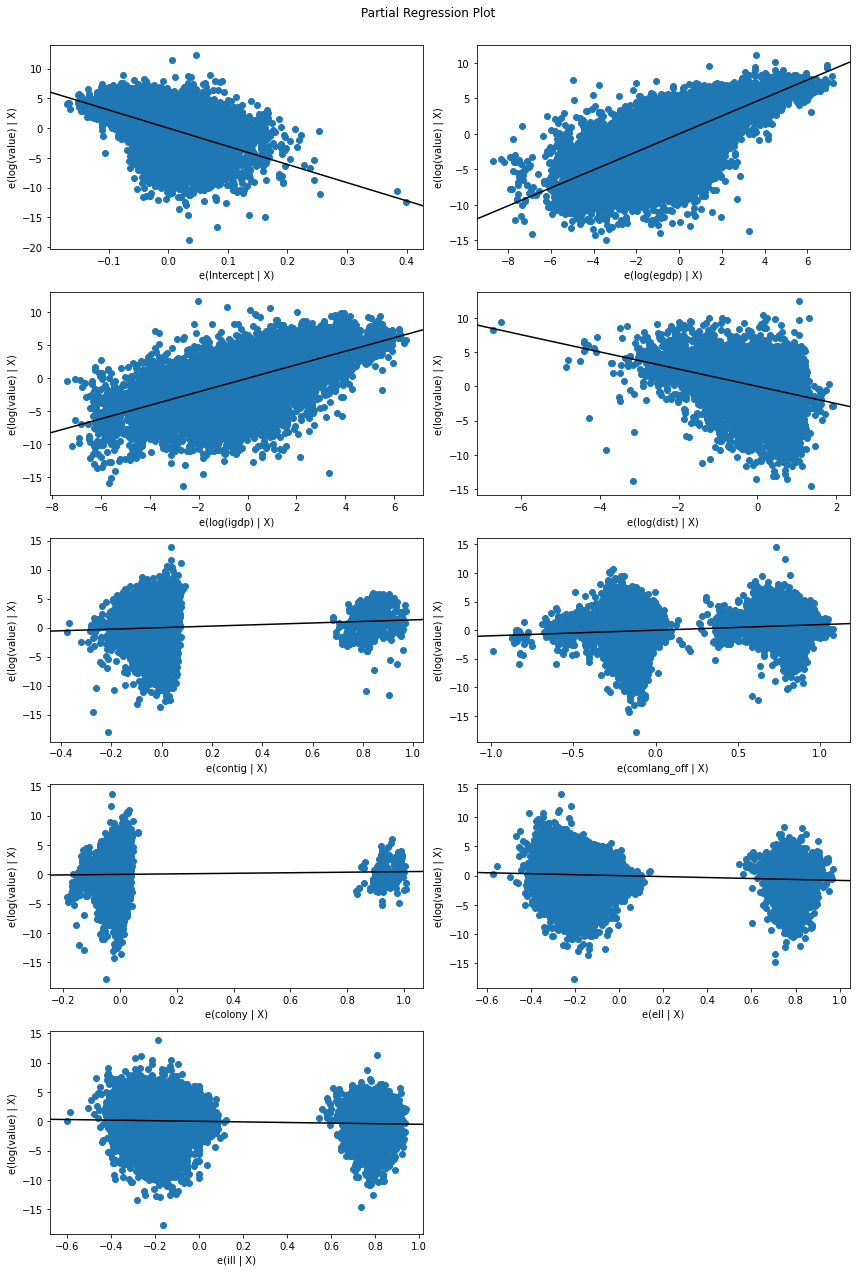

In [17]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig = plt.figure(figsize=(12,18))
fig = sm.graphics.plot_partregress_grid(result2, fig=fig)